In [1]:
import dataset as dataset
import importlib
importlib.reload(dataset)
import utils as utils
import tensorflow as tf
import numpy as np
import model as model
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"
# tf.compat.v1.enable_eager_execution()
num_classes = 8

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


## Define architecture

In [2]:
# actual definition of tf models
class Unet(tf.keras.Model):

  def __init__(self, strName, intChans, strMode):
    super(Unet, self).__init__(name=strName)
    self.moduleIn = tf.keras.Sequential(
        [model.net_conv("conv_1", intChans[0], 3, 1, 1)], name="in_0")

    self.moduleMain = model.Unet("main", intChans, strMode)

    self.moduleOut = tf.keras.Sequential([
            model.net_conv("conv_1", intChans[0], 3, 2, 1),
            model.net_acti("acti_1"),
            model.net_conv("conv_2", 3, 3, 2, 1),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(1000, activation='relu'),
            tf.keras.layers.Dense(8, activation=None)], name="out_0")

  # end
  def call(self, tenIn):
    tenOut = self.moduleIn(tenIn)
    tenOut = self.moduleMain(tenOut)
    return self.moduleOut(tenOut)
  # end

## Import dataset

In [3]:
train_txt = './train_6.txt'
val_txt = './val_6.txt'
batch_size = 1
size = (128, 256)
architecture_depth = []
for i in range(5):
    architecture_depth.insert(0, np.power(2, (8 - i)))
# mainmodel = Unet('main', architecture_depth, 'regular')
mainmodel = Unet('main', architecture_depth, strMode='regular')
next_batch = dataset.input_fn(
    dataset_name='bw',
    train_txt_paths=[train_txt],
    eval_txt_paths=[val_txt],
    is_train=True,
    image_size=size,
    batch_size=batch_size)
next_batch_val = dataset.input_fn(
    dataset_name='bw',
    train_txt_paths=[train_txt],
    eval_txt_paths=[val_txt],
    is_train=False,
    image_size=size,
    batch_size=batch_size)
inputs = next_batch['frames']
inputs_val = next_batch_val['frames']

inputs.set_shape([batch_size, size[0], size[1], 20 * 3])
inputs_val.set_shape([batch_size, size[0], size[1], 20 * 3])

class_predict = mainmodel(inputs)
class_predict_val = mainmodel(inputs_val)

class_gt = next_batch['label']  # a scalar of int32
class_gt_val = next_batch_val['label']

class_gt = tf.cast(class_gt, tf.float32)
class_gt_val = tf.cast(class_gt_val, tf.float32)

print(class_gt.shape)



Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.
(1, 8)


## Define losses

In [4]:
# define losses
loss = tf.nn.sigmoid_cross_entropy_with_logits(
    labels=class_gt, logits=class_predict)
# loss = tf.reduce_mean(tf.abs(class_one_hot - class_predict))
# Evaluation metrics
prediction = tf.to_int32(tf.argmax(class_predict, 1))
ground_truth = tf.to_int32(tf.argmax(class_gt, 1))
correct_prediction = tf.equal(prediction, ground_truth)

prediction_val = tf.to_int32(tf.argmax(class_predict_val, 1))
ground_truth_val = tf.to_int32(tf.argmax(class_gt_val, 1))
correct_prediction_val = tf.equal(prediction_val, ground_truth_val)

accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
accuracy_val = tf.reduce_mean(tf.cast(correct_prediction_val, tf.float32))

global_step = tf.compat.v1.train.get_or_create_global_step()
learning_rate = tf.compat.v1.train.exponential_decay(
  5e-4, global_step, 5000, 0.9, staircase=False)
opt = tf.compat.v1.train.AdamOptimizer(
    learning_rate=learning_rate).minimize(loss, global_step=global_step)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `tf.cast` instead.


In [ ]:
max_steps = 500000
fetch_list = [opt, accuracy, accuracy_val, class_predict, class_gt, loss]
trainable_var_list = [
      var for var in tf.compat.v1.trainable_variables()
  ]
saver = tf.compat.v1.train.Saver(trainable_var_list, max_to_keep=5)
sess = tf.compat.v1.Session()
sess.run(tf.compat.v1.global_variables_initializer())
all_loss = np.zeros(max_steps, dtype=float)
sses = np.zeros(max_steps)
for step in range(max_steps):
    _, out_accuracy, out_accuracy_val, out_class_predict, out_class_gt, out_loss = sess.run(fetch_list)
    all_loss[step] = np.mean(out_loss)
    if step % 100 == 0:
        print('Accuracy:', out_accuracy)
        print('Validation Accuracy:', out_accuracy_val)
        print('Correct class label:', out_class_gt)
        print('Class prediction:', out_class_predict)
        print('Average loss:', np.mean(all_loss[np.where(all_loss)]))
    if step % 1000 == 0:
        saver.save(sess, '%s/model.ckpt' % ('/home/bmild/comp-color/data/ckpts_bw'), global_step=step)

Accuracy: 0.0
Validation Accuracy: 0.0
Correct class label: [[0. 1. 0. 0. 0. 1. 0. 0.]]
Class prediction: [[ 0.09022607 -0.6135348   1.0218763   0.37412906  0.21128953  0.1489905
  -0.04050732  0.47233903]]
Average loss: 0.8835334777832031
Accuracy: 0.0
Validation Accuracy: 0.0
Correct class label: [[0. 1. 0. 1. 0. 0. 0. 0.]]
Class prediction: [[-0.91821176 -0.22617368  0.5609126  -3.0695276  -0.7953009   0.09259983
  -3.8857741  -2.0790462 ]]
Average loss: 1.3040835749874315
Accuracy: 0.0
Validation Accuracy: 0.0
Correct class label: [[0. 0. 0. 0. 1. 0. 0. 1.]]
Class prediction: [[-2.1330967  -1.398543   -1.2146986  -1.1770732  -2.6682673  -0.87154144
  -0.03961059 -2.4003072 ]]
Average loss: 0.9776884284129932
Accuracy: 1.0
Validation Accuracy: 0.0
Correct class label: [[1. 0. 1. 0. 0. 1. 0. 0.]]
Class prediction: [[-0.21177523 -1.1508851  -0.9698996  -1.0640658  -0.5440562  -0.77953994
  -1.1719407  -0.6832905 ]]
Average loss: 0.8668480931883338
Accuracy: 0.0
Validation Accuracy: 0.

## Inference

In [3]:
# import dataset as dataset
# import importlib
# importlib.reload(dataset)
# import utils as utils
# import tensorflow as tf
import numpy as np
import model as model

# tf.compat.v1.enable_eager_execution()
num_classes = 8
model_path = '/home/bmild/comp-color/data/ckpts_img_2'
train_txt = './train_6.txt'
val_txt = './val_6.txt'
batch_size = 1
size = (128, 256)
architecture_depth = []
for i in range(5):
    architecture_depth.insert(0, np.power(2, (8 - i)))
# mainmodel = Unet('main', architecture_depth, 'regular')
mainmodel = Unet('main', architecture_depth, strMode='regular')

next_batch_val = dataset.input_fn(
    dataset_name='bw',
    train_txt_paths=[val_txt],
    eval_txt_paths=[val_txt],
    is_train=False,
    image_size=size,
    batch_size=1)

inputs_val = next_batch_val['frames']
inputs_val.set_shape([batch_size, size[0], size[1], 20 * 3])

class_predict_val = mainmodel(inputs_val)
class_gt_val = next_batch_val['label']
class_gt_val = tf.cast(class_gt_val, tf.float32)

prediction = tf.to_int32(tf.argmax(class_predict_val, 1))
ground_truth = tf.to_int32(tf.argmax(class_gt_val, 1))
correct_prediction = tf.equal(prediction, ground_truth)

sess = tf.compat.v1.Session()
sess.run(tf.compat.v1.global_variables_initializer())
saver_restore = tf.train.Saver([var for var in tf.trainable_variables()])
ckpt = tf.train.get_checkpoint_state(model_path)
restore_path = ckpt.model_checkpoint_path
saver_restore.restore(sess, restore_path)




Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.
Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /home/bmild/comp-color/data/ckpts_img_2/model.ckpt-206000


In [4]:
accuracy = np.zeros((num_classes,))
gt_class = np.zeros((num_classes,))
confusion = np.zeros((num_classes, num_classes))
num_eval = 300
predict_scores = np.zeros((num_eval, num_classes))
gt_scores = np.zeros((num_eval, num_classes))

fetch = [class_predict_val[0], ground_truth[0], class_gt_val[0]]
for step in range(num_eval):
    out_class_predict, out_ground_truth, out_ground_truth_vec = sess.run(fetch)
    predict_scores[step] = out_class_predict
    gt_scores[step] = out_ground_truth_vec

    pred_sort_ind = np.argsort(out_class_predict)
    gt_num_lables = int(out_ground_truth_vec.sum())
    for classi in range(num_classes):
        if out_ground_truth_vec[classi] >= 1.:
            if classi in pred_sort_ind[-gt_num_lables:]:
                accuracy[classi] += 1.
            for j in range(gt_num_lables):
                confusion[classi, pred_sort_ind[-j-1]] += 1
            
    gt_class[int(out_ground_truth)] += 1.
    if step % 50 == 0:
        print(out_class_predict, out_ground_truth)
print(accuracy)
print(gt_class)


[ 0.983293   -1.975512   -1.3300525  -2.56689     0.13584793 -1.6377487
 -1.3763703   0.10243258] 3
[-0.6113797  -1.1284708  -1.0045705  -1.4972255  -1.1072314   0.09843361
 -1.9193841  -1.5653815 ] 3
[-1.5993073   0.32782856 -0.35756513 -0.6991368  -2.349725    0.28140545
 -2.8370333  -2.516684  ] 1
[-0.96324927 -0.91679966 -0.5204661  -1.3142786  -0.9259929  -0.8050307
 -1.2607256  -1.1006527 ] 1
[-2.2883773   0.3633876  -0.0886876  -0.10780191 -2.7310655   0.21814954
 -3.5424967  -2.928753  ] 0
[-1.6325133  -0.83356833 -1.1208258  -0.708747   -1.1118088  -0.06580579
 -1.9930292  -1.7731433 ] 3
[87. 28. 40. 12. 56. 59.  1. 32.]
[130.  48.  19.  51.  28.  12.  11.   1.]


In [6]:
print(inputs_val.shape)

(1, 128, 256, 60)


In [16]:
accuracy_global = 0
accuracy = np.zeros((num_classes,))
confusion = np.zeros((num_classes, num_classes))

for i in range(predict_scores.shape[0]):
    pred_classi = np.argsort(predict_scores[i])
    gt_num_lables = int(gt_scores[i].sum())
    labels = np.where(gt_scores[i])[0]
#     print(gt_num_lables, labels)
    if gt_scores[i][pred_classi[-1]] == 1:
        accuracy[pred_classi[-1]] += 1
    
    for j in range(gt_num_lables):
        confusion[labels[j], pred_classi[-1-j]] += 1
#         if gt_scores[i][pred_classi[-(j+1)]] == 1:
#             accuracy_global += 1
        
print(confusion)
print(accuracy)

[[56.  4. 13.  0. 11. 45.  0.  1.]
 [ 6. 11.  2.  0.  6. 27.  0.  0.]
 [ 9. 13. 18.  3. 15.  9.  0.  6.]
 [17. 14.  5.  3.  8. 27.  0.  0.]
 [22.  9. 17.  5. 17. 13.  0. 19.]
 [16. 17. 14.  7. 15. 13.  1.  5.]
 [11.  5.  6.  1. 10.  5.  0.  2.]
 [ 7.  9.  8. 10. 30.  6.  3. 16.]]
[56. 11. 22.  0. 12. 41.  0.  1.]


In [13]:
confusion = np.array([[56.,  4., 13.,  0., 11., 45.,  0.,  1.],
 [ 6., 11.,  2.,  0.,  6., 27.,  0.,  0.],
 [ 9., 13., 18.,  3., 15.,  9.,  0.,  6.],
 [17., 14.,  5.,  3.,  8., 27.,  0.,  0.],
 [22.,  9., 17.,  5., 17., 13.,  0., 19.],
 [16., 17., 14.,  7., 15., 13.,  1.,  5.],
 [11.,  5.,  6.,  1., 10.,  5.,  0.,  2.],
 [ 7.,  9.,  8., 10., 30.,  6.,  3., 16.]])

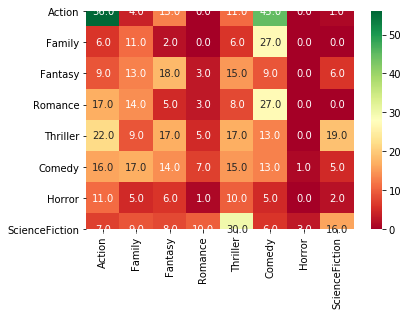

<Figure size 864x720 with 0 Axes>

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

index = ['Action','Family','Fantasy','Romance','Thriller','Comedy','Horror','ScienceFiction']
columns = ['Action','Family','Fantasy','Romance','Thriller','Comedy','Horror','ScienceFiction']
cm_df = pd.DataFrame(confusion, columns, index)

fig, ax = plt.subplots()
plt.figure(figsize=(12, 10))

sns.heatmap(cm_df, fmt='', cmap='RdYlGn', annot=True, ax=ax)
fig.savefig('./conf.png')
plt.show() # ta-da!


(0, 100)

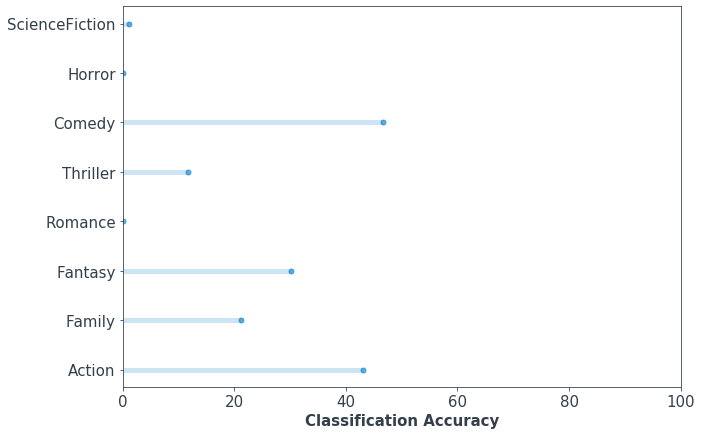

In [30]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'

accuracy_pd = pd.Series(perc*100, 
                        index=['Action','Family','Fantasy','Romance','Thriller','Comedy','Horror','ScienceFiction'])
df = pd.DataFrame({'percentage' : accuracy_pd})
my_range=list(range(1,len(df.index)+1))
my_range2=list(range(1,len(df.index)+2))

fig, ax = plt.subplots(figsize=(10, 7))

# create for each expense type an horizontal line that starts at x = 0 with the length 
# represented by the specific expense percentage value.
plt.hlines(y=my_range, xmin=0, xmax=perc*100, color='#007ACC', alpha=0.2, linewidth=5)
# plt.hlines(y=my_range2, xmin=0, xmax=perc*100, color='r', alpha=0.2, linewidth=5)

# create for each expense type a dot at the level of the expense percentage value
plt.plot(accuracy_pd, my_range, "o", markersize=5, color='#007ACC', alpha=0.6)

# set labels
ax.set_xlabel('Classification Accuracy', fontsize=15, fontweight='black', color = '#333F4B')
ax.set_ylabel('')
# set axis
ax.tick_params(axis='both', which='major', labelsize=15)
plt.yticks(my_range, df.index)
plt.xlim((0,100))


In [37]:
import matplotlib.pyplot as plt

y = int(100 * perc)
z = [45., 22., 22.,  1., 15., 21.,  6., 26.]

ax = plt.subplot(111)
ax.bar(x-0.2, y, width=0.2, color='b', align='center')
ax.bar(x, z, width=0.2, color='g', align='center')

plt.show()

TypeError: only size-1 arrays can be converted to Python scalars

In [40]:
(100 * perc).astype(np.int)

array([43, 21, 30,  0, 11, 46,  0,  1])

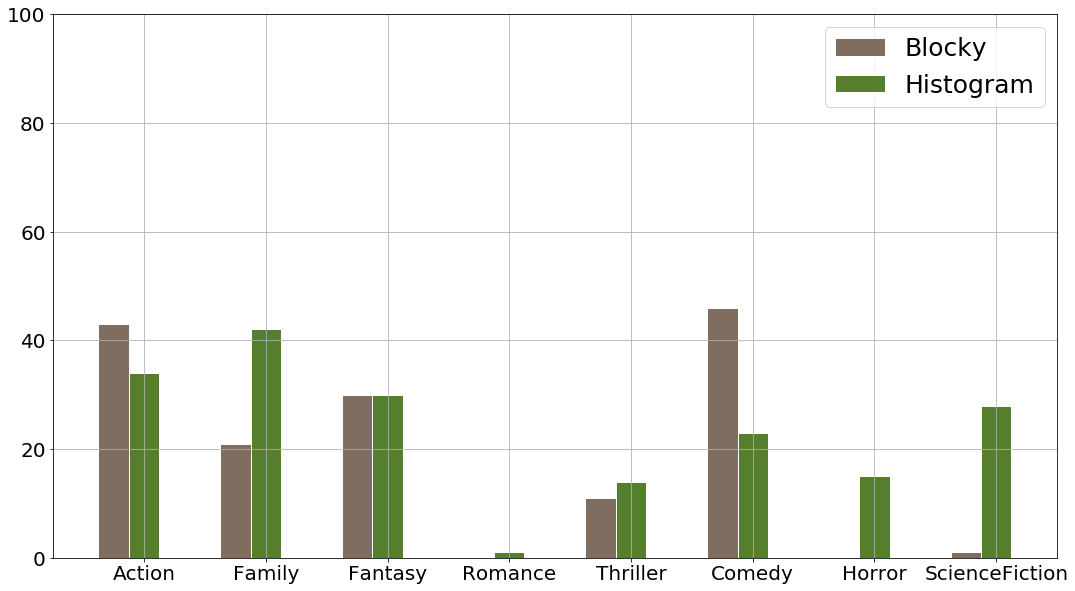

In [10]:
import numpy as np
import matplotlib.pyplot as plt
 
# set width of bar
barWidth = 0.25
index=['Action','Family','Fantasy','Romance','Thriller','Comedy','Horror','ScienceFiction']
 
# set height of bar
bars1 = (np.array([43, 21, 30,  0, 11, 46,  0,  1])).astype(np.int)
bars2 = (100 * np.array([0.34883721, 0.42307692, 0.30555556, 0.01351351, 0.14563107, 0.23595506, 0.15384615, 0.28888889])).astype(np.int)
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.figure(figsize=(18, 10))
plt.bar(r1, bars1, color='#7f6d5f', width=barWidth, edgecolor='white', label='var1')
plt.bar(r2, bars2, color='#557f2d', width=barWidth, edgecolor='white', label='var2')
 
# Add xticks on the middle of the group bars
plt.xticks([r + barWidth for r in range(len(bars1))], index, fontsize=20)
# plt.yticks([r + barWidth for r in range(len(bars1))], r1, fontsize=20)
plt.yticks(fontsize=20, rotation=0)
plt.ylim([0, 100])
# Create legend & Show graphic
plt.legend(['Blocky', 'Histogram'], fontsize=25)
plt.grid('on')
plt.show()


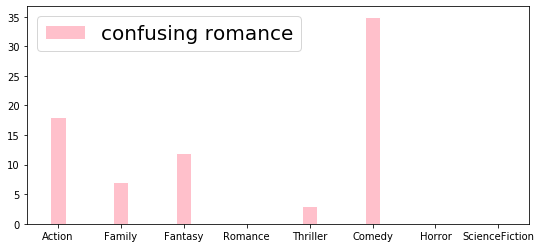

In [47]:
bar_romance = [18.,  7., 12.,  0.,  3.,  35.,  0.,  0.]

plt.figure(figsize=(9, 4))
plt.bar(index, bar_romance, color='#ffc0cb', width=barWidth, edgecolor='white', label='confusing romance')
plt.legend(fontsize=20)
plt.savefig('./conf-romance.png')
plt.show()